# Forecasting Univariate Time Series

This tutorial introduces the basics of forecasting univariate time series using the `sktime` library in Python. It covers the basic data structures, how to use the forecasting API, and demonstrates how simple you can change the forecasting model to achieve different results. Forecasting with exogenous variables is covered in the next tutorial.

**Duration:** ~10 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Understand univariate pandas structure in sktime
- Use the sktime forecasting API with `y` and `fh` arguments
- Work with relative and absolute forecast horizons
- Be able to perform forecasting with any model available

## 1. Loading a Simple Dataset

Let's start by loading the classic airline passengers dataset, which contains monthly totals of international airline passengers from 1949 to 1960.

This dataset is loaded as pandas series, where the index represents the dates/timepoints and the values represent the time series values.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sktime.datasets import Airline

# Load the airline dataset
y = Airline().load("y")
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In sktime, we do not have a specific data structure for timeseries. Instead, we assume some conventions for pandas, polars or dask dataframes. The fit & predict interface is the same, for all types of timeseries representions. To keep it simple, we will use pandas series in this tutorial.


You can find some useful plotting functions in the `sktime.utils.plotting` module, which can be used to visualize the time series data.


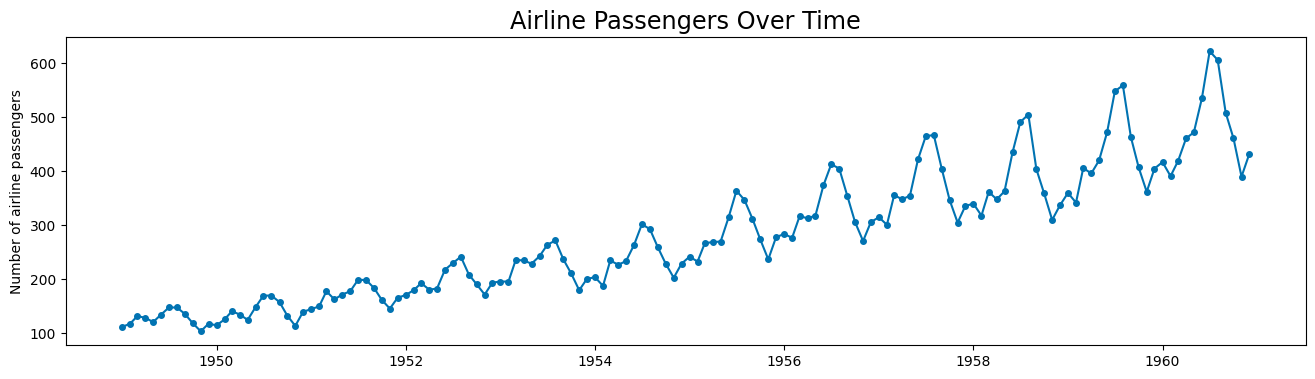

In [2]:
from sktime.utils.plotting import plot_series

# Be sure to have seaborn installed
plot_series(y, title="Airline Passengers Over Time")
plt.show()

We use a simple train-test split to visualize the training and testing data. When doing this separation, it is important to consider the temporal ordering of the data. We will use the first 80% of the data for training and the remaining 20% for testing.

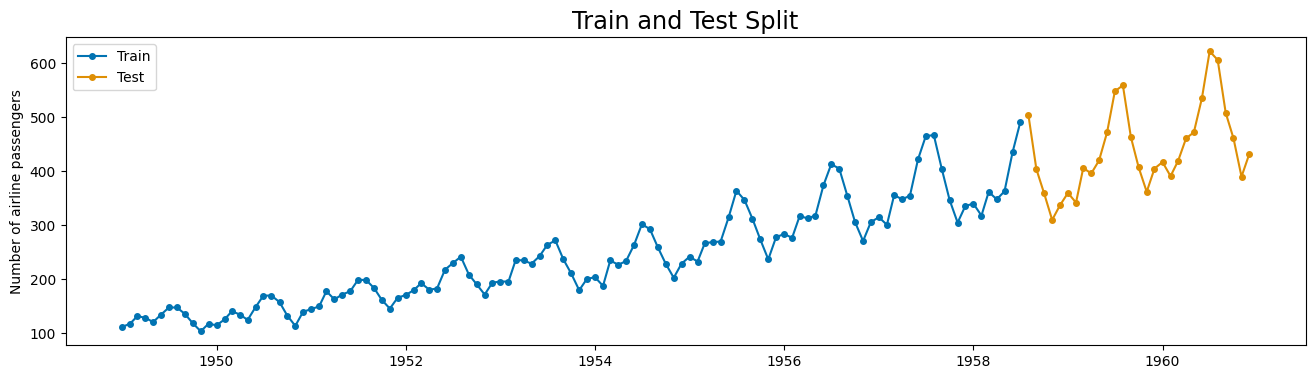

In [3]:
from sktime.split.temporal_train_test_split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=0.2)
# Plot the training and testing data
plot_series(y_train, y_test, labels=["Train", "Test"], title="Train and Test Split")
plt.show()

## 2. sktime Forecasting API: `fit` and `predict`

The core of sktime's forecasting API involves two key methods:
- `fit(y, X=None, fh=None)`: To train the model on the provided time series data. It must receive the time series data `y` as a pandas Series or DataFrame. Some models also require the forecast horizon `fh` during fitting, which can be specified as an argument (e.g. fh=[1,2,3] for 3-steps ahead forecasting). The `X` argument is used to pass exogenous variables, and we will cover this in detail in the following tutorials. 
- `predict(fh=None, X=None)`: To generate forecasts for the specified horizon. The `predict` method takes a forecast horizon (`fh`) as an argument, which can be either relative (e.g., 1, 2, 3) or absolute (e.g., specific dates). If the model already received the forecasting horizon during `fit`, it is not needed to provide it again during prediction.


In the following tutorials, we will see how the extra argument `X` can be used to pass exogenous variables.

The magic part of sktime is that you can use any model available in the library, and it will work with the same interface. This means you can easily switch between different forecasting models without changing your code structure.

### 2.1 Fitting a forecasting model

The basic API is as follows:

In [4]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Fit the model
forecaster = ExponentialSmoothing(trend="add", seasonal="mul", sp=12)
forecaster.fit(y_train)

ExponentialSmoothing(seasonal='mul', sp=12, trend='add')

Note that **all hyperparameters are set at initialization**. This means that, once you define your model, you can pack it and use it later without needing to redefine the hyperparameters. This is particularly useful for reproducibility and deployment.


### 2.2. Forecasting

Once we have a fitted model, we are ready to forecast.

To generate a 3-step ahead forecast, we can call `predict` with a relative forecast horizon of `[1, 2, 3]`. This means we want to forecast the next three time points after the last point in the training data.


In [5]:
forecaster.predict(fh=[1, 2, 3])

1958-08    485.501967
1958-09    426.476369
1958-10    370.784500
Freq: M, Name: Number of airline passengers, dtype: float64

In [6]:
forecaster.cutoff

PeriodIndex(['1958-07'], dtype='period[M]')

The horizon can also be negative, which means we want to perform in-sample forecasting.

**Note:** not all forecasters support in-sample forecasting. If you try to use a forecaster that does not support it, you will get an error when calling `predict` with a negative horizon.

In [7]:
forecaster.predict(fh=[-1, 0])

1958-06    420.549448
1958-07    484.048396
Freq: M, Name: Number of airline passengers, dtype: float64

The `fh` argument can be either relative or absolute. By passing the dates directly, we can specify exactly what time points we want to forecast. 

In [8]:
forecaster.predict(fh=pd.period_range("1958-08", "1958-10", freq="M"))

1958-08    485.501967
1958-09    426.476369
1958-10    370.784500
Freq: M, Name: Number of airline passengers, dtype: float64

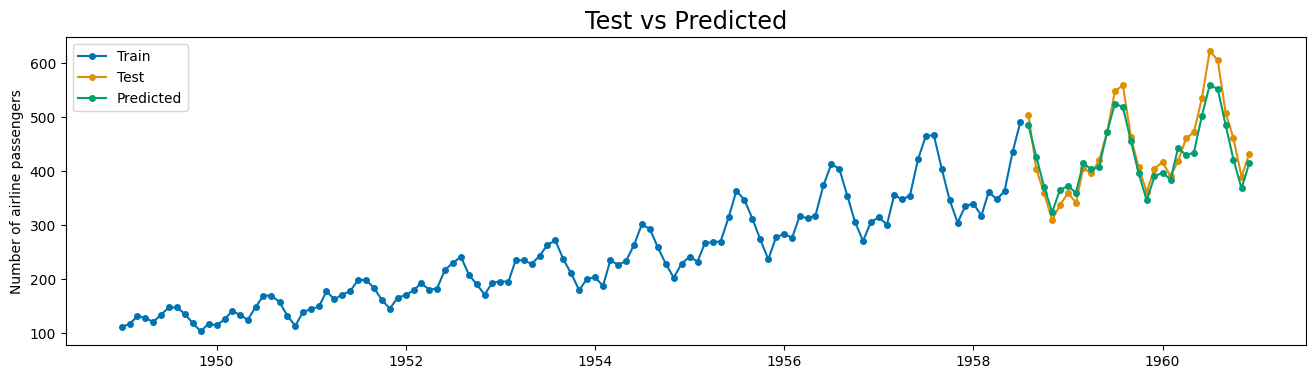

In [9]:
# We can get the index of the test set to use as the forecast horizon
fh_test = y_test.index

y_pred = forecaster.predict(fh=fh_test)

plot_series(
    y_train,
    y_test,
    y_pred,
    labels=["Train", "Test", "Predicted"],
    title="Test vs Predicted",
)
plt.show()

We can inspect the fitted parameters of the forecaster using the `get_fitted_params` method. This can be useful to understand how the model was trained and what parameters were used.

In [10]:
forecaster.get_fitted_params()

{'initial_level': 55.203279463164456,
 'initial_slope': None,
 'initial_seasons': array([1.99110616, 1.91377355, 2.19653087, 2.11895094, 2.13077844,
        2.45351383, 2.71413586, 2.668305  , 2.33049516, 2.01464148,
        1.75252009, 1.96470404]),
 'aic': 488.39559228004646,
 'bic': 532.3145063338585,
 'aicc': 495.52059228004646}

Note that the hyperparameters, set during initialization, are not included in the fitted parameters. This is because they are not learned from the data but rather set by the user. They, on the other hand, can be accessed using the `get_params` method.

In [11]:
forecaster.get_params()

{'damped_trend': False,
 'damping_trend': None,
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': None,
 'initialization_method': 'estimated',
 'method': None,
 'minimize_kwargs': None,
 'optimized': True,
 'random_state': None,
 'remove_bias': False,
 'seasonal': 'mul',
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_trend': None,
 'sp': 12,
 'start_params': None,
 'trend': 'add',
 'use_boxcox': None,
 'use_brute': True}

## 3. Using a different model

To switch to a different model, we simply need to change the model class in the initialization. For example, we can switch from `ExponentialSmoothing` to `Chronos` without any friction - we just need to have the required dependencies. In this case, we need to install `torch` and `transformers` to use the `ChronosForecaster`.


In [12]:
from sktime.forecasting.chronos import ChronosForecaster

ChronosForecaster.get_class_tag("python_dependencies")

['torch', 'transformers', 'accelerate']

In [13]:
from sktime.forecasting.chronos import ChronosForecaster

forecaster = ChronosForecaster(model_path="amazon/chronos-t5-tiny")
forecaster.fit(y_train)

ChronosForecaster(model_path='amazon/chronos-t5-tiny')

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Test vs Predicted (Chronos)'}, ylabel='Number of airline passengers'>)

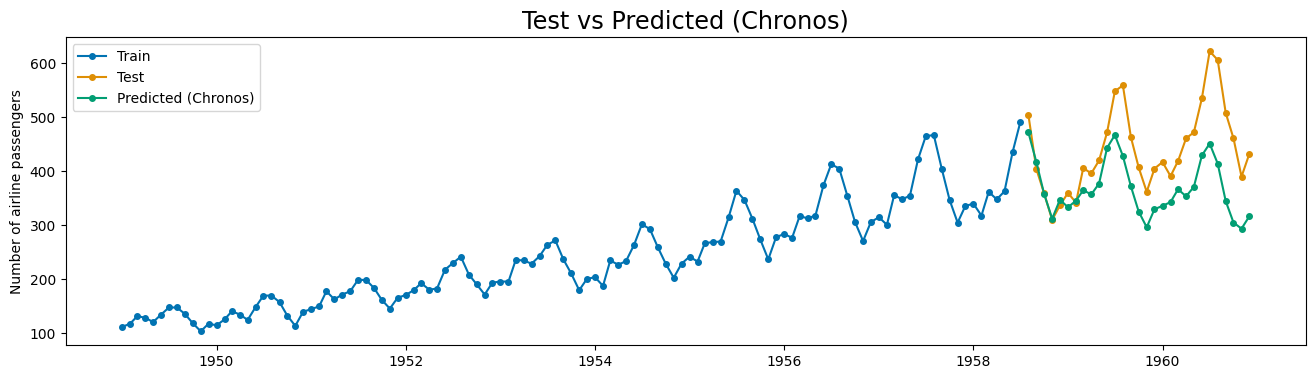

In [14]:
y_pred_chronos = forecaster.predict(fh_test)

plot_series(
    y_train,
    y_test,
    y_pred_chronos,
    labels=["Train", "Test", "Predicted (Chronos)"],
    title="Test vs Predicted (Chronos)",
)

You can check all models availables in sktime by checking Estimator Overview in documentation, or the api reference.

You can also use `all_estimators` to get a list of all available estimators in sktime, including forecasting models. 

In [17]:
from sktime.registry import all_estimators

all_estimators(estimator_types="forecaster", return_names=True, as_dataframe=True)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
...,...,...
113,VAR,<class 'sktime.forecasting.var.VAR'>
114,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
115,VARReduce,<class 'sktime.forecasting.var_reduce.VARReduce'>
116,VECM,<class 'sktime.forecasting.vecm.VECM'>


This marketplace is yours to explore, and you can easily switch between models to find the one that works best for your data.

## Key Takeaways

* The sktime library provides a unified API for forecasting univariate time series, allowing you to easily switch between different models.
* The `fit` and `predict` methods are the core of the forecasting API, with `fit` used for training the model and `predict` for generating forecasts.
* The forecast horizon can be specified as relative or absolute, giving you flexibility in how you generate forecasts.
* You can explore various forecasting models available in sktime and switch between them seamlessly.